<a href="https://colab.research.google.com/github/YongWanJin/KDTteam5_semiproject/blob/main/code/%EC%BD%94%EB%A1%9C%EB%82%98%EC%9D%B4%ED%9B%84_%EB%A7%A4%EC%B6%9C%EC%95%A1%ED%9A%8C%EB%B3%B5_%EC%8B%9C%EA%B0%81%ED%99%94(%EB%A6%AC%EB%89%B4%EC%96%BC%2C%20%EB%AF%B8%EC%99%84).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 구글 드라이브에 접근
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 한글 글꼴 설치
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

In [2]:
# 필요한 모듈 불러오기
from glob import glob      
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import folium
from IPython.display import display 

================================================================================

In [3]:
### 원본 데이터 raw data 불러오기

# 1. 상권코드&추정매출액 (2017~2022Q1) 불러오기&병합
# 변수명 : sales
# 역할 : 매출증가율 계산에 사용될 데이터가 들어있음.

file_names = glob("/content/gdrive/MyDrive/datafile/추정매출(2017~2022Q1)/*.csv") 

sales = pd.DataFrame()    
for file_name in file_names : 
    temp = pd.read_csv(file_name, encoding='CP949')
    sales = pd.concat([sales, temp])               
del(temp)

sales.reset_index(inplace=True, drop=True)          

display(sales)

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,분기당_매출_금액,분기당_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2021,1,A,골목상권,2110001,이북5도청사,CS100001,한식음식점,626851391,25502,...,157,15667,7253,108,1098,2013,4344,7792,7568,28
1,2021,1,A,골목상권,2110001,이북5도청사,CS100008,분식전문점,122957138,12039,...,0,6679,4293,52,926,1222,2698,3404,2670,9
2,2021,1,A,골목상권,2110001,이북5도청사,CS100009,호프-간이주점,5093349,177,...,9,124,36,0,0,9,18,62,71,3
3,2021,1,A,골목상권,2110001,이북5도청사,CS100010,커피-음료,13507733,1359,...,8,356,881,0,243,260,213,288,235,5
4,2021,1,A,골목상권,2110001,이북5도청사,CS200001,일반교습학원,37551380,128,...,0,56,72,0,0,8,96,8,16,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825955,2022,1,A,골목상권,2110001,이북5도청사,CS200001,일반교습학원,46710839,136,...,0,96,40,0,0,0,120,16,0,3
825956,2022,1,A,골목상권,2110001,이북5도청사,CS100010,커피-음료,20931521,2018,...,0,955,1009,0,382,342,380,581,279,2
825957,2022,1,A,골목상권,2110001,이북5도청사,CS100009,호프-간이주점,5119924,159,...,18,115,18,0,0,18,18,54,44,1
825958,2022,1,A,골목상권,2110001,이북5도청사,CS100008,분식전문점,92420017,10197,...,0,5872,3689,26,401,1191,2273,3093,2576,3


In [4]:
# 2. 상권코드&행정동코드&좌표값 불러오기
# 변수명 : location
# 역할 : 구 별로 구분, 지도시각화에 필요한 데이터가 들어있음.
location = pd.read_csv("/content/gdrive/MyDrive/datafile/상권영역_위도경도추가.csv")

# 3. 행정동코드&행정동이름 불러오기
# 변수명 : name
# 역할 : 구 별로 구분, 지도시각화에 필요한 데이터가 들어있음.
name = pd.read_csv("/content/gdrive/MyDrive/datafile/행정동코드-이름_매치파일.csv")

In [5]:
### sales 전처리 : sales 데이터에서 필요한 부분만 골라내기

# 분기 순서에 맞춰 필요한 연도(2019년 3분기 ~ 2022년 1분기) 추출
sales = sales[ sales['기준_년_코드'] >= 2019  ] # 연도 추출
sales.drop( sales[(sales['기준_년_코드']==2019)&(sales['기준_분기_코드']<=2)].index, inplace=True) # 필요없는 분기 제거

# 필요한 업종(식당업)만 추출
sales['서비스_업종_코드'] = sales['서비스_업종_코드'].str.replace(pat=r'[CS]',repl=r'', regex=True).astype('int')
sales = sales[ sales['서비스_업종_코드'] <= 100010]  

# 필요한 columns 골라내기
sales = sales[['기준_년_코드', '기준_분기_코드', '상권_코드', '분기당_매출_금액', '상권_구분_코드_명', '서비스_업종_코드_명']]

display(sales) # 결과

,기준_년_코드,기준_분기_코드,상권_코드,분기당_매출_금액,상권_구분_코드_명,서비스_업종_코드_명
0,2021,1,2110001,626851391,골목상권,한식음식점
1,2021,1,2110001,122957138,골목상권,분식전문점
2,2021,1,2110001,5093349,골목상권,호프-간이주점
3,2021,1,2110001,13507733,골목상권,커피-음료
12,2021,1,2110002,361894416,골목상권,한식음식점
...,...,...,...,...,...,...
825947,2022,1,2110002,346852071,골목상권,한식음식점
825956,2022,1,2110001,20931521,골목상권,커피-음료
825957,2022,1,2110001,5119924,골목상권,호프-간이주점
825958,2022,1,2110001,92420017,골목상권,분식전문점


In [6]:
### name의 상권코드와 location의 행정동코드 병합하기 (location에 병합)

# location 전처리 : 필요한 행만 골라내기
location = location[['상권_코드', '행정동_코드', '경도', '위도']]

# name 전처리 : location의 행정동코드와 자릿수를 같게 만들기
name['행정동코드'] = name['행정동코드']/100
name['행정동코드'] = name['행정동코드'].astype(int)

# name 전처리 : 필요한 열, 필요한 행만 골라내기
name = name[name['시도명']=='서울특별시']
name = name[['행정동코드', '시군구명', '읍면동명']]

# location과 name을 location에 join
location = pd.merge(location, name, left_on='행정동_코드', right_on='행정동코드')
location.drop('행정동_코드', axis='columns', inplace=True) # 중복되는 열 제거

display(location) # 결과

,상권_코드,경도,위도,행정동코드,시군구명,읍면동명
0,2110753,126.908844,37.448687,11545710,금천구,시흥제5동
1,2110748,126.904810,37.448765,11545710,금천구,시흥제5동
2,2110754,126.910150,37.452869,11545710,금천구,시흥제5동
3,2130238,126.910095,37.451617,11545710,금천구,시흥제5동
4,2110427,127.070978,37.634469,11350611,노원구,하계1동
...,...,...,...,...,...,...
3677,2130166,126.918620,37.594260,11380590,은평구,응암제2동
3678,2130113,127.094587,37.606387,11260690,중랑구,신내2동
3679,2130051,127.017283,37.562266,11140665,중구,동화동
3680,2130102,127.062547,37.604597,11230750,동대문구,이문제2동


In [ ]:
### location과 sales 병합하기 (sales에 병합)
sales = pd.merge(sales, location, left_on = '상권_코드', right_on='상권_코드')
sales = sales[['기준_년_코드', '기준_분기_코드', '시군구명', '읍면동명', '분기당_매출_금액', '상권_구분_코드_명', '서비스_업종_코드_명', '경도', '위도']]

# 어디선가 꼬여버린 순서를 분기 순서에 맞게 재배치
temp1 = sales[sales['기준_년_코드']==2019].sort_values(by='기준_분기_코드')
for y in range(2020, 2023) :
    temp2 = sales[sales['기준_년_코드']==y].sort_values(by='기준_분기_코드')
    temp1 = pd.concat([temp1, temp2])
sales = temp1
del(temp1)
del(temp2)

### 연도와 분기를 구분해주는 라벨링 작업 : 추후 반복작업을 위해서
sales_time = sales[['기준_년_코드', '기준_분기_코드']].drop_duplicates()
sales_time['시점_구분_변수'] = [p for p in range(len(sales_time))]
sales = pd.merge(sales, sales_time)

In [74]:
display(sales) # 결과물

,기준_년_코드,기준_분기_코드,시군구명,읍면동명,분기당_매출_금액,상권_구분_코드_명,서비스_업종_코드_명,경도,위도,시점_구분_변수
0,2019,3,종로구,평창동,617366771,골목상권,한식음식점,126.956884,37.609345,0
1,2019,3,영등포구,양평제2동,1715934320,골목상권,한식음식점,126.892219,37.536260,0
2,2019,3,영등포구,양평제2동,1715934320,골목상권,한식음식점,126.892219,37.536260,0
3,2019,3,영등포구,양평제2동,1715934320,골목상권,한식음식점,126.892219,37.536260,0
4,2019,3,중구,명동,2170985300,발달상권,양식음식점,126.977667,37.567626,0
...,...,...,...,...,...,...,...,...,...,...
223759,2022,1,금천구,독산제2동,58629176,골목상권,패스트푸드점,126.901897,37.463747,10
223760,2022,1,금천구,독산제2동,19662439,골목상권,치킨전문점,126.901897,37.463747,10
223761,2022,1,금천구,독산제2동,160504059,골목상권,분식전문점,126.901897,37.463747,10
223762,2022,1,금천구,시흥제1동,199970430,골목상권,분식전문점,126.902834,37.447169,10


데이터 전처리 완료. 이제 이 salse 변수로부터 원하는 데이터를 뽑아내서 시각화를 하면 된다.

================================================================================

In [9]:
### 전분기 대비 매출액 증가율을 구 별로 집계

# 집계한 결과들을 기입하기 위한 변수 inc_gu 생성
# ex) 2019년4분기 : 2019년3분기 대비 2019년4분기의 매출액 증가율
index = [gu for gu in sales['시군구명'].unique()]
columns = ["2019년4분기", "2020년1분기", "2020년2분기", "2020년3분기", "2020년4분기",
           "2021년1분기", "2021년2분기", "2021년3분기", "2021년4분기", "2022년1분기"]
inc_gu = pd.DataFrame(index = index, columns = columns)  

# 증가율 집계
for p in range( len(sales['시점_구분_변수'].unique())-1 ) :

    means_before = sales[ sales['시점_구분_변수']==p ].groupby('시군구명')['분기당_매출_금액'].mean()
    means_before = np.array(means_before) # 구 단위로 전 분기 매출 평균 계산

    means_now = sales[ sales['시점_구분_변수']==p+1 ].groupby('시군구명')['분기당_매출_금액'].mean()
    means_now = np.array(means_now) # 구 단위로 이번 분기 매출 평균 계산

    inc = (means_now - means_before)/means_before*100 # 전분기 대비 이번 분기 매출 평균 증가율 계산
    inc = np.round(inc, 2).reshape(25,1)
    inc = inc.tolist()
    inc_gu.iloc[:,[p]] = inc # 입력

display(inc_gu) # 결과



,2019년4분기,2020년1분기,2020년2분기,2020년3분기,2020년4분기,2021년1분기,2021년2분기,2021년3분기,2021년4분기,2022년1분기
종로구,10.78,-18.52,4.96,-2.78,-7.45,-8.26,19.57,-14.81,29.28,-15.09
영등포구,11.18,-13.19,8.0,-8.38,-9.19,-9.08,13.08,-4.87,17.09,-13.25
중구,8.75,-14.27,13.39,-10.06,-14.18,-13.27,22.72,-5.93,12.27,-15.6
강동구,6.1,-15.67,4.85,-4.71,-9.92,-7.67,14.07,-8.87,14.6,-11.82
금천구,3.49,-14.19,5.15,-8.29,-12.27,-11.82,14.53,-7.1,21.4,-13.24
송파구,18.62,-21.56,4.17,-7.74,-8.87,-10.83,22.45,-10.53,20.37,-13.37
강북구,9.12,-15.37,6.6,-5.72,-6.53,-6.48,13.27,-14.6,20.29,-14.98
구로구,8.1,-13.67,9.2,-4.65,-5.82,-7.47,16.84,-10.83,20.44,-14.19
성북구,12.27,-15.06,8.04,-8.31,-9.91,-11.56,20.28,-6.77,12.09,-12.4
동작구,5.93,-10.1,9.77,-8.96,-8.71,-9.58,15.23,-3.09,9.52,-12.18


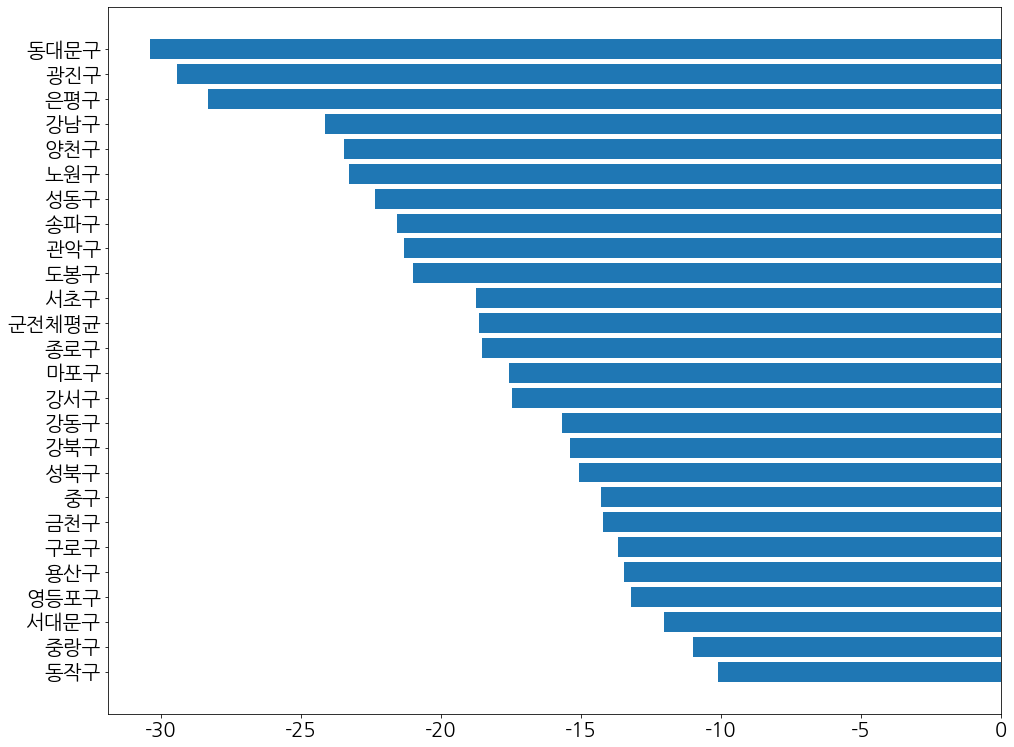

In [95]:
### 1-1. 코로나 직후(2020년 1분기)에 타격을 가장 많이 받은 구 순으로 막대그래프

# 막대그래프 그릴때 사용할 데이터프레임 inc_gu_2020q1 생성

inc_gu_2020q1 = pd.DataFrame()
inc_gu_2020q1['시군구명'] = inc_gu.index
inc_gu_2020q1['2020년1분기'] = inc_gu['2020년1분기'].values

inc_mean = inc_gu_2020q1['2020년1분기'].mean()
inc_mean_df = pd.DataFrame({'시군구명':['전체평균'], '2020년1분기':[inc_mean]})
inc_gu_2020q1 = pd.concat([inc_gu_2020q1, inc_mean_df])

inc_gu_2020q1.sort_values(by='2020년1분기', ascending=False, inplace=True)


# 가로 막대그래프 생성

fig, ax = plt.subplots()

y = np.arange(len(inc_gu_2020q1))  # 세로축에 들어갈 값
values = inc_gu_2020q1['2020년1분기']   # 가로축에 들어갈 값

plt.barh(y, values)
plt.yticks(y, inc_gu_2020q1['시군구명'].values.tolist())


plt.rc('font', family='NanumGothic') # 한글 글꼴 설정
matplotlib.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

plt.rcParams["figure.figsize"] = [10,15] # 그래프 전체 크기
plt.rc('font', size=20)  # 글자 크기

# 군전체평균만 색깔 다르게지정

# 상위 5개는 좀더 튀는 색깔로

# x축 인덱스 맨 위로

# 막대그래프 왼쪽에 붙이기

# 제목 지정

plt.show()



In [12]:
inc_gu_2020q1['2020년1분기'] = inc_gu_2020q1['2020년1분기']*(-1) # 심각한 지역이 진한 색으로 나오게하기 위함.

In [94]:
### 1-2. 1-1의 결과를 지도시각화

# 서울을 군별로 나눈 지도 데이터
# 출처 : https://github.com/southkorea/seoul-maps/tree/master/juso/2015/json
seoul_map = "/content/gdrive/MyDrive/datafile/seoul_municipalities_geo_simple_match.json"

gu_csv = pd.read_csv('/content/gdrive/MyDrive/datafile/시구별_경도위도.csv')
gu_csv = gu_csv[ gu_csv['do']=='서울']

for gu, lat, lng in zip(gu_csv['city'].to_list(), gu_csv['longitude'].to_list(), gu_csv['latitude'].to_list()) :
    folium.Marker([lat, lng], tooltip='{}'.format(gu))

center = [37.541, 126.986]
folium.Marker(center) ## ?? Marker함수는 직접 숫자로 입력한거 아니면 인식을 못하나??


m = folium.Map(location=[37.5838699,127.0565831],zoom_start=10)

center = [37.541, 126.986]
#center = [latitude, longtitude]
#center = [위도    , 경도      ]
folium.Choropleth(geo_data = seoul_map,
                  name = 'choropleth',
                  data = inc_gu_2020q1,
                  columns = ('시군구명', '2020년1분기'),
                  key_on = 'feature.properties.SIG_KOR_NM', # SIG_KOR_NM
                  fill_color='RdYlBu',
                  legend_name='코로나직후_매출증가율').add_to(m)
                          # 정보데이터와 지도 데이터 결합 => choropleth
m

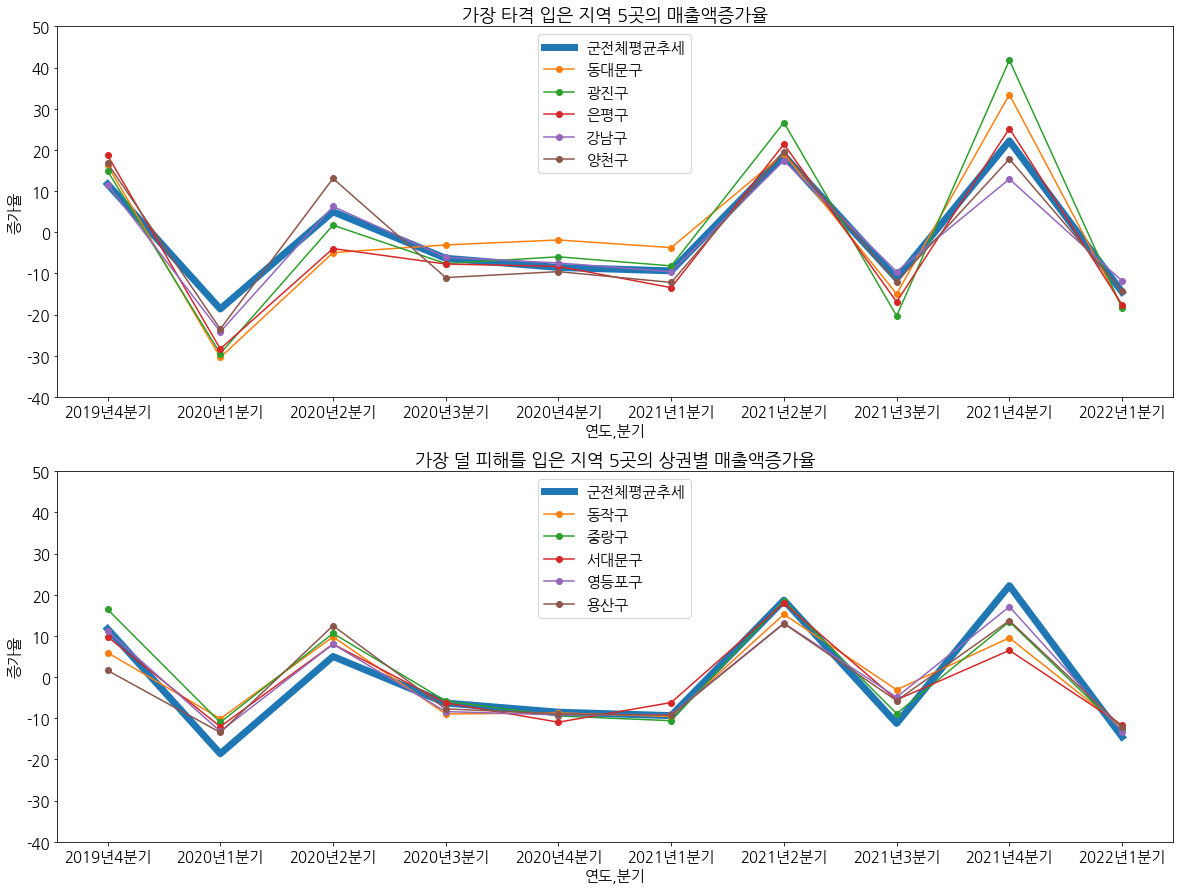

In [73]:
### 매출 회복 추세 : 코로나 직후 가장 타격이 심했던 구 5개 vs 가장 덜 타격받은 구 5개

# 최악 5개 군 그래프에 쓸 데이터프레임 inc_gu_trand1 생성
inc_gu_trand1 = inc_gu.sort_values(by='2020년1분기') # 코로나 직후 큰 타격을 받았던 곳 순으로 재배치
trand_means = []   # 평균값 구하기
for i in range(10) :
    mean = inc_gu_trand1.iloc[:, [i]].mean().values[0]
    trand_means.append(mean)
inc_gu_trand1.loc[len(inc_gu_trand1)] = trand_means  # 평균 추세 추가
inc_gu_trand1.rename(index={25:'군전체평균추세'}, inplace=True)


# 덜 타격받은 5개 군 그래프에 쓸 데이터프레임 inc_gu_trand2 생성
inc_gu_trand2 = inc_gu.sort_values(by='2020년1분기', ascending=False) # 코로나 직후 비교적 적은 타격을 받았던 곳 순으로 재배치
trand_means = []   # 평균값 구하기
for i in range(10) :
    mean = inc_gu_trand2.iloc[:, [i]].mean().values[0]
    trand_means.append(mean)
inc_gu_trand2.loc[len(inc_gu_trand2)] = trand_means  # 평균 추세 추가
inc_gu_trand2.rename(index={25:'군전체평균추세'}, inplace=True)


# 최악 5개 군 그래프 그리기
plt.subplot(2, 1, 1) # 2행1열 공간의 첫번째 부분에 들어갈 그래프

x = np.arange(len(inc_gu_trand1.columns))  # 가로축에 들어갈 값

plt.plot(x, inc_gu_trand1.iloc[25], linewidth = '7.0') # 평균 추세, 선 두께 설정
for i in range(5) :
    plt.plot(x, inc_gu_trand1.iloc[i], marker='o') # 최악 5개 군 각각의 추세

plt.title('가장 타격 입은 지역 5곳의 매출액증가율') # 그래프 제목
plt.xlabel('연도,분기') # x축 제목
plt.xticks(x, inc_gu_trand1.columns.to_list()) # 실제로 x축에 표기할 내용
plt.ylabel('증가율') # y축 제목
plt.ylim(-40, 50) # y축 표기범위
legend_list = ['군전체평균추세'] + [i for i in inc_gu_trand1.index.to_list()] # 범주 생성
plt.legend(legend_list) # 범주 출력
plt.rc('font', size=15)  # 글자 크기


# 덜 타격받은 5개 군 그래프 그리기
plt.subplot(2, 1, 2) # 2행1열 공간의 두번째 부분에 들어갈 그래프

plt.plot(x, inc_gu_trand2.iloc[25], linewidth = '7.0') # 평균 추세, 선 두께 설정
for i in range(5) :
    plt.plot(x, inc_gu_trand2.iloc[i], marker='o') # 덜타격받은 5개 군 각각의 추세

plt.title('가장 덜 피해를 입은 지역 5곳의 상권별 매출액증가율') # 그래프 제목
plt.xlabel('연도,분기') # x축 제목
plt.xticks(x, inc_gu_trand2.columns.to_list()) # 실제로 x축에 표기할 내용
plt.ylabel('증가율') # y축 제목
plt.ylim(-40, 50) # y축 표기범위
legend_list = ['군전체평균추세'] + [i for i in inc_gu_trand2.index.to_list()] # 범주 생성
plt.legend(legend_list) # 범주 출력
plt.rc('font', size=15)  # 글자 크기

plt.rcParams["figure.figsize"] = [20,15] # 그래프 전체 크기

plt.show() # 결과

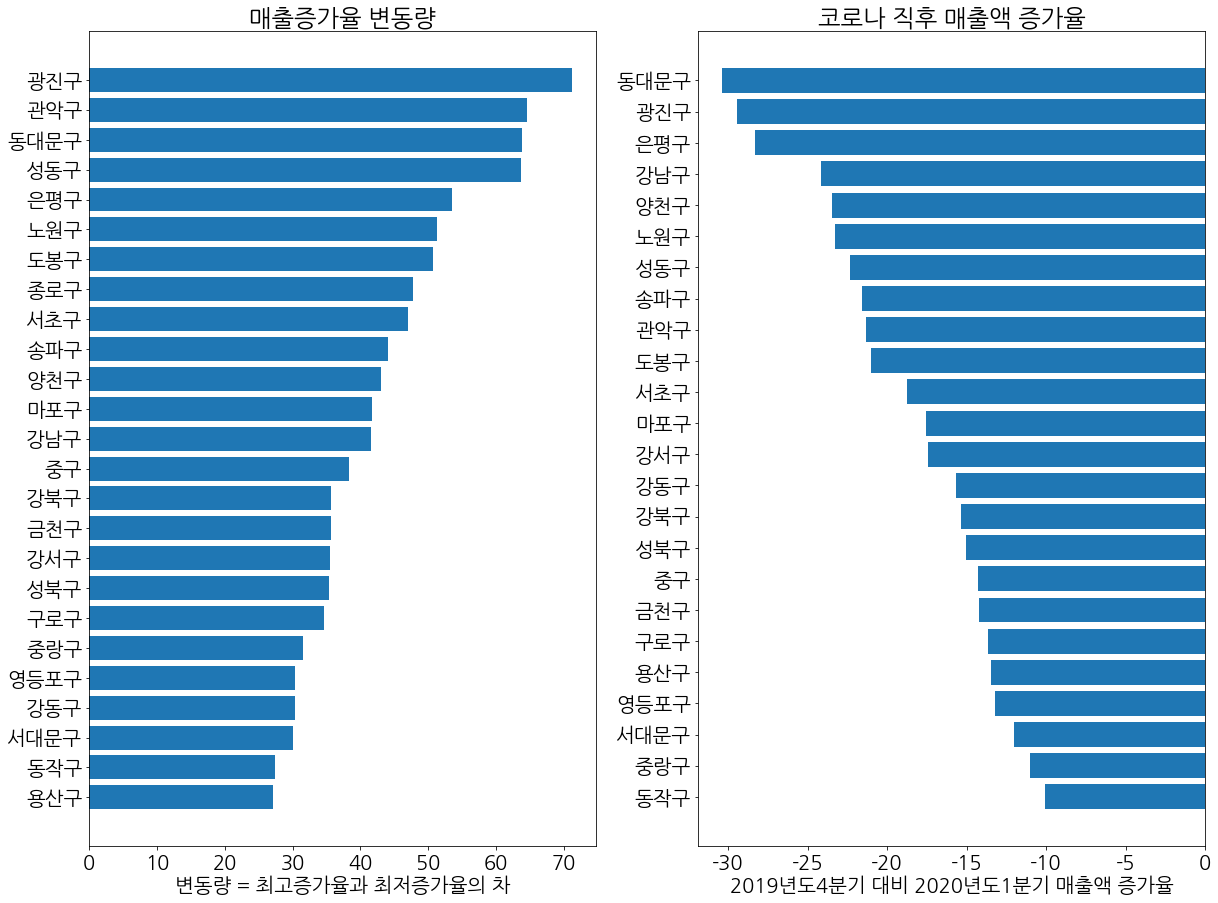

In [136]:
### 변동폭이 큰 순서대로 막대그래프

# 이 막대그래프를 그리기 위해 쓸 데이터프레임 inc_var 생성
inc_var = pd.DataFrame()
inc_var['시군구명'] = inc_gu.index.to_list()

vars = []
var = 0
for i in range(len(inc_gu)) :
    var = inc_gu.iloc[i].max() - inc_gu.iloc[i].min()
    vars.append(var)
inc_var['변동폭'] = vars

inc_var.sort_values(by='변동폭', inplace=True)

# 막대그래프 생성 : 변동량

plt.subplot(1, 2, 1)
y = np.arange(len(inc_var))  # 세로축에 들어갈 값
values = inc_var['변동폭']   # 가로축에 들어갈 값
plt.barh(y, values) # 그래프 생성

plt.rc('font', family='NanumGothic') # 한글 글꼴 설정
matplotlib.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지
plt.title('매출증가율 변동량') # 그래프 제목
plt.yticks(y, inc_var['시군구명'].values.tolist()) # y축에 표기할 값
plt.xlabel('변동량 = 최고증가율과 최저증가율의 차') # x축 설명
plt.rc('font', size=20)  # 글자 크기

# 막대그래프 생성 : 코로나 이후 타격

inc_gu_2020q1.drop(inc_gu_2020q1[inc_gu_2020q1['시군구명']=='군전체평균'].index, axis='rows', inplace=True)

plt.subplot(1, 2, 2)
y = np.arange(len(inc_gu_2020q1))  # 세로축에 들어갈 값
values = inc_gu_2020q1['2020년1분기']   # 가로축에 들어갈 값
plt.barh(y, values) # 그래프 생성

plt.rc('font', family='NanumGothic') # 한글 글꼴 설정
matplotlib.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지
plt.title('코로나 직후 매출액 증가율') # 그래프 제목
plt.yticks(y, inc_gu_2020q1['시군구명'].values.tolist()) # y축에 표기할 값
plt.xlabel('2019년도4분기 대비 2020년도1분기 매출액 증가율') # x축 설명
plt.rc('font', size=20)  # 글자 크기


plt.rcParams["figure.figsize"] = [16,13] # 그래프 전체 크기


plt.show()

In [92]:
inc_var['변동폭'] = inc_var['변동폭'] * (-1) # 변동폭 큰 지역이 붉은색으로 나오게 만듦

In [93]:
### 변동폭을 지도 시각화

seoul_map = "/content/gdrive/MyDrive/datafile/seoul_municipalities_geo_simple_match.json"

gu_csv = pd.read_csv('/content/gdrive/MyDrive/datafile/시구별_경도위도.csv')
gu_csv = gu_csv[ gu_csv['do']=='서울']

for gu, lat, lng in zip(gu_csv['city'].to_list(), gu_csv['longitude'].to_list(), gu_csv['latitude'].to_list()) :
    folium.Marker([lat, lng], tooltip='{}'.format(gu))

center = [37.541, 126.986]
folium.Marker(center) ## ?? Marker함수는 직접 숫자로 입력한거 아니면 인식을 못하나??


m = folium.Map(location=[37.5838699,127.0565831],zoom_start=10)

center = [37.541, 126.986]
#center = [latitude, longtitude]
#center = [위도    , 경도      ]
folium.Choropleth(geo_data = seoul_map,
                  name = 'choropleth',
                  data = inc_var,
                  columns = ('시군구명', '변동폭'),
                  key_on = 'feature.properties.SIG_KOR_NM', # SIG_KOR_NM
                  fill_color='RdYlBu',
                  legend_name='매출증가율 변동량').add_to(m)
                          # 정보데이터와 지도 데이터 결합 => choropleth
m


코로나로 큰 피해를 입은 지역은 비교적 피해가 적었던 지역보다 매출증가율 변동폭이 심했다. 안정된 소득이 보장되지 않는다. 

큰 피해를 입은 지역에서 불안정한 소득증가율이 나타나는 원인은 무엇일까?




================================================================================

In [55]:
### 상권별 비교 : 큰 피해를 입은 지역 5개 vs 안그런 지역 5개 

# sales에서 큰 피해를 입은 지역 5개 추출
sales_bad5 = sales[ sales['시군구명'] == '동대문구' ]
for gu in ['광진구', '은평구', '강남구', '양천구'] :
    temp = sales[ sales['시군구명'] == gu ]
    sales_bad5 = pd.concat([sales_bad5, temp])

# 상권별 전분기 대비 매출증가율 입력할 곳 생성
index = [i for i in sales_bad5['상권_구분_코드_명'].unique()]
columns = ["2019년4분기", "2020년1분기", "2020년2분기", "2020년3분기", "2020년4분기",
           "2021년1분기", "2021년2분기", "2021년3분기", "2021년4분기", "2022년1분기"]
incbad5_dist = pd.DataFrame(index = index, columns = columns)  

# 증가율 집계
for p in range( len(sales_bad5['시점_구분_변수'].unique())-1 ) :

    means_before = sales_bad5[ sales_bad5['시점_구분_변수']==p ].groupby('상권_구분_코드_명')['분기당_매출_금액'].mean()
    means_before = np.array(means_before) # 상권 단위로 전 분기 매출 평균 계산

    means_now = sales_bad5[ sales_bad5['시점_구분_변수']==p+1 ].groupby('상권_구분_코드_명')['분기당_매출_금액'].mean()
    means_now = np.array(means_now) # 상권 단위로 이번 분기 매출 평균 계산

    inc = (means_now - means_before)/means_before*100 # 전분기 대비 이번 분기 매출 평균 증가율 계산
    inc = np.round(inc, 2).reshape(4,1)
    inc = inc.tolist()
    incbad5_dist.iloc[:,[p]] = inc # 입력

display(incbad5_dist) # 결과

,2019년4분기,2020년1분기,2020년2분기,2020년3분기,2020년4분기,2021년1분기,2021년2분기,2021년3분기,2021년4분기,2022년1분기
골목상권,8.07,-16.14,10.89,-5.68,-8.8,-8.84,18.9,-9.79,12.64,-12.33
발달상권,5.9,-36.93,-13.19,24.75,-2.43,3.3,9.5,-10.42,39.43,-5.22
전통시장,12.02,-19.56,4.63,-3.69,-8.21,-9.16,18.84,-13.25,25.55,-14.84
관광특구,12.2,-15.59,9.3,-8.21,-7.2,-9.64,16.92,-10.56,18.6,-11.76


In [56]:
# sales에서 가장 덜 피해를 입은 지역 5개 추출
sales_less5 = sales[ sales['시군구명'] == '동작구' ]
for gu in ['중랑구', '서대문구', '영등포구', '용산구'] :
    temp = sales[ sales['시군구명'] == gu ]
    sales_less5 = pd.concat([sales_less5, temp])

# 상권별 전분기 대비 매출증가율 입력할 곳 생성
index = [i for i in sales_less5['상권_구분_코드_명'].unique()]
columns = ["2019년4분기", "2020년1분기", "2020년2분기", "2020년3분기", "2020년4분기",
           "2021년1분기", "2021년2분기", "2021년3분기", "2021년4분기", "2022년1분기"]
incless5_dist = pd.DataFrame(index = index, columns = columns)  

# 증가율 집계
for p in range( len(sales_less5['시점_구분_변수'].unique())-1 ) :

    means_before = sales_less5[ sales_less5['시점_구분_변수']==p ].groupby('상권_구분_코드_명')['분기당_매출_금액'].mean()
    means_before = np.array(means_before) # 상권 단위로 전 분기 매출 평균 계산

    means_now = sales_less5[ sales_less5['시점_구분_변수']==p+1 ].groupby('상권_구분_코드_명')['분기당_매출_금액'].mean()
    means_now = np.array(means_now) # 상권 단위로 이번 분기 매출 평균 계산

    inc = (means_now - means_before)/means_before*100 # 전분기 대비 이번 분기 매출 평균 증가율 계산
    inc = np.round(inc, 2).reshape(4,1)
    inc = inc.tolist()
    incless5_dist.iloc[:,[p]] = inc # 입력

display(incless5_dist) # 결과

,2019년4분기,2020년1분기,2020년2분기,2020년3분기,2020년4분기,2021년1분기,2021년2분기,2021년3분기,2021년4분기,2022년1분기
골목상권,9.21,-19.02,8.11,-4.97,-7.88,-9.7,24.99,-13.53,24.19,-13.96
발달상권,9.96,-27.3,-36.56,2.91,-4.42,-13.79,31.76,-16.98,57.11,-17.2
전통시장,16.45,-22.57,-3.09,-3.98,-8.2,-9.9,17.59,-15.89,31.06,-16.52
관광특구,30.37,-24.53,4.7,-5.19,-5.82,-7.92,15.47,-11.67,21.57,-14.41


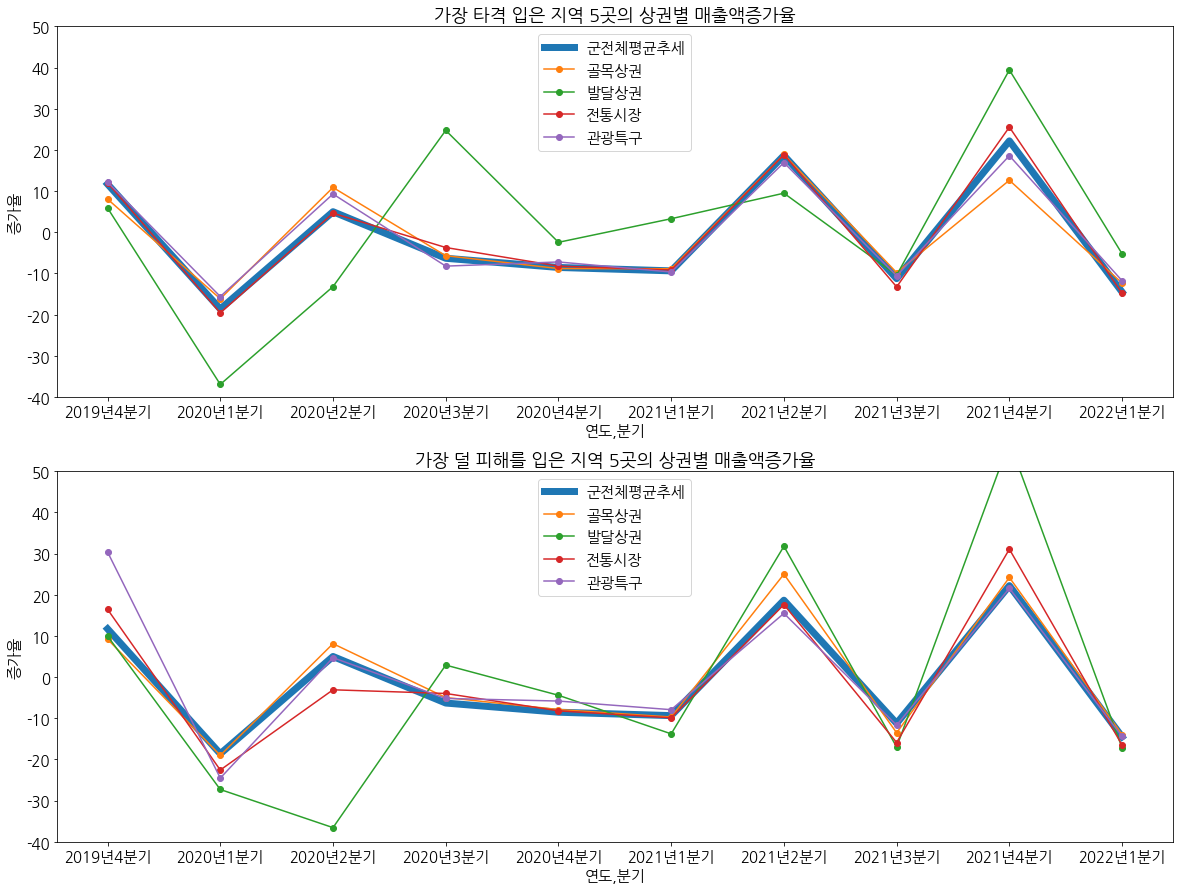

In [75]:
# 그래프 그리기

# 타격이 심각한 곳
plt.subplot(2, 1, 1) # 2행1열 공간의 첫번째 부분에 들어갈 그래프

plt.plot(x, inc_gu_trand2.iloc[25], linewidth = '7.0') # 평균 추세, 선 두께 설정
for i in range(4) :
    plt.plot(x, incbad5_dist.iloc[i], marker='o')

plt.xlabel('연도,분기') # x축 제목
plt.xticks(x, incbad5_dist.columns.to_list()) # 실제로 x축에 표기할 내용

plt.ylabel('증가율') # y축 제목

plt.ylim(-40, 50) # y축 표기범위

legend_list = ['군전체평균추세'] + [i for i in incbad5_dist.index.to_list()] # 범주
plt.legend(legend_list, loc = 'upper center')

plt.title('가장 타격 입은 지역 5곳의 상권별 매출액증가율')
#plt.rcParams["figure.figsize"] = [20,9] # 그래프 전체 크기
plt.rc('font', size=15)  # 글자 크기


# 타격이 가장 덜 심각한 곳
plt.subplot(2, 1, 2) # 2행1열 공간의 두번째 부분에 들어갈 그래프

plt.plot(x, inc_gu_trand2.iloc[25], linewidth = '7.0') # 평균 추세, 선 두께 설정
for i in range(4) :
    plt.plot(x, incless5_dist.iloc[i], marker='o')

plt.xlabel('연도,분기') # x축 제목
plt.xticks(x, incless5_dist.columns.to_list()) # 실제로 x축에 표기할 내용

plt.ylabel('증가율') # y축 제목

plt.ylim(-40, 50) # y축 표기범위

legend_list = ['군전체평균추세'] + [i for i in incless5_dist.index.to_list()] # 범주
plt.legend(legend_list)

plt.title('가장 덜 피해를 입은 지역 5곳의 상권별 매출액증가율')
plt.rcParams["figure.figsize"] = [20,15] # 그래프 전체 크기
plt.rc('font', size=15)  # 글자 크기


plt.show() # 결과

['분식전문점', '양식음식점', '일식음식점', '제과점', '중식음식점', '치킨전문점', '커피-음료', '패스트푸드점', '한식음식점', '호프-간이주점']


In [129]:
### 업종별 비교 : 큰 피해를 입은 지역 5개 vs 안그런 지역 5개 

# sales에서 큰 피해를 입은 지역 5개 추출
# : 위에서 이미 만들었던 sales_bad5 변수 이용

# 업종별 전분기 대비 매출증가율 입력할 곳 생성
index = [i for i in sales_bad5['서비스_업종_코드_명'].unique()]
columns = ["2019년4분기", "2020년1분기", "2020년2분기", "2020년3분기", "2020년4분기",
           "2021년1분기", "2021년2분기", "2021년3분기", "2021년4분기", "2022년1분기"]
incbad5_type = pd.DataFrame(index = index, columns = columns)

# 증가율 집계
for p in range( len(sales_bad5['시점_구분_변수'].unique())-1 ) :

    means_before = sales_bad5[ sales_bad5['시점_구분_변수']==p ].groupby('서비스_업종_코드_명')['분기당_매출_금액'].mean()
    means_before = np.array(means_before) # 업종 단위로 전 분기 매출 평균 계산

    means_now = sales_bad5[ sales_bad5['시점_구분_변수']==p+1 ].groupby('서비스_업종_코드_명')['분기당_매출_금액'].mean()
    means_now = np.array(means_now) # 업종 단위로 이번 분기 매출 평균 계산

    inc = (means_now - means_before)/means_before*100 # 전분기 대비 이번 분기 매출 평균 증가율 계산
    inc = np.round(inc, 2).reshape(10,1)
    inc = inc.tolist()
    incbad5_type.iloc[:,[p]] = inc # 입력

incbad5_type['순서정렬'] = index
incbad5_type.sort_values(by='순서정렬', inplace=True)
incbad5_type.drop('순서정렬', axis='columns', inplace=True)

display(incbad5_type) # 결과

,2019년4분기,2020년1분기,2020년2분기,2020년3분기,2020년4분기,2021년1분기,2021년2분기,2021년3분기,2021년4분기,2022년1분기
분식전문점,17.17,-23.94,4.06,-1.8,-1.63,-8.96,17.52,-8.37,50.34,-19.03
양식음식점,10.1,-17.98,4.14,-5.54,-8.33,-8.67,18.53,-16.57,28.18,-14.41
일식음식점,13.92,-17.55,9.48,-8.72,-20.4,-25.74,32.05,-21.97,46.47,-27.78
제과점,23.75,-23.13,1.97,4.92,0.14,-5.85,11.21,-13.96,24.55,-11.88
중식음식점,1.31,-12.29,9.43,-12.84,-15.33,-17.27,17.94,-9.38,5.78,-16.52
치킨전문점,33.94,-22.27,12.16,-3.81,-0.29,-4.39,16.38,-14.35,31.49,-18.58
커피-음료,13.81,-18.89,0.48,-0.46,-11.96,-13.28,4.16,-1.72,-1.77,-4.89
패스트푸드점,10.38,-12.67,3.37,-2.14,-0.97,-6.41,8.41,3.7,5.86,-3.94
한식음식점,3.92,-16.14,11.09,-4.36,-12.95,-2.64,30.07,-3.91,-0.12,-11.97
호프-간이주점,0.99,-22.2,1.9,-3.01,-4.34,-5.69,15.25,-10.93,14.07,-2.82


In [131]:
# sales에서 가장 덜 피해를 입은 지역 5개 추출
# : 위에서 이미 만들었던 sales_less5 변수 이용

# 업종별 전분기 대비 매출증가율 입력할 곳 생성
index = [i for i in sales_less5['서비스_업종_코드_명'].unique()]
columns = ["2019년4분기", "2020년1분기", "2020년2분기", "2020년3분기", "2020년4분기",
           "2021년1분기", "2021년2분기", "2021년3분기", "2021년4분기", "2022년1분기"]
incless5_type = pd.DataFrame(index = index, columns = columns)  

# 증가율 집계
for p in range( len(sales_less5['시점_구분_변수'].unique())-1 ) :

    means_before = sales_less5[ sales_less5['시점_구분_변수']==p ].groupby('서비스_업종_코드_명')['분기당_매출_금액'].mean()
    means_before = np.array(means_before) # 업종 단위로 전 분기 매출 평균 계산

    means_now = sales_less5[ sales_less5['시점_구분_변수']==p+1 ].groupby('서비스_업종_코드_명')['분기당_매출_금액'].mean()
    means_now = np.array(means_now) # 업종 단위로 이번 분기 매출 평균 계산

    inc = (means_now - means_before)/means_before*100 # 전분기 대비 이번 분기 매출 평균 증가율 계산
    inc = np.round(inc, 2).reshape(10,1)
    inc = inc.tolist()
    incless5_type.iloc[:,[p]] = inc # 입력

incless5_type['순서정렬'] = index
incless5_type.sort_values(by='순서정렬', inplace=True)
incless5_type.drop('순서정렬', axis='columns', inplace=True)

display(incless5_type) # 결과

,2019년4분기,2020년1분기,2020년2분기,2020년3분기,2020년4분기,2021년1분기,2021년2분기,2021년3분기,2021년4분기,2022년1분기
분식전문점,-0.02,-18.33,-1.29,-2.19,-13.12,-12.54,14.93,-8.05,11.13,-9.93
양식음식점,13.55,-22.9,0.51,-5.58,-6.93,-7.91,20.64,-17.44,33.97,-15.2
일식음식점,19.94,-20.8,0.52,-9.41,-21.43,-25.43,34.87,-28.52,73.94,-27.54
제과점,14.62,-16.89,7.26,-11.6,-11.63,-17.97,18.0,-4.21,9.94,-21.01
중식음식점,29.0,-32.76,-8.42,2.45,-3.99,-2.03,12.28,-15.95,40.14,-17.3
치킨전문점,10.98,-19.7,1.66,-1.44,-7.08,-10.53,25.95,-5.76,8.12,-13.04
커피-음료,17.59,-7.84,-5.52,-0.19,-0.9,-7.78,3.17,0.87,-0.02,-10.19
패스트푸드점,6.44,-19.45,-0.02,-2.08,-5.53,-12.29,19.73,-12.19,18.05,-11.9
한식음식점,19.1,-24.37,2.99,-0.25,-5.39,-3.94,14.74,-14.07,31.34,-18.11
호프-간이주점,7.23,-20.94,1.4,1.27,-3.77,-6.3,10.2,-12.02,27.95,-12.01


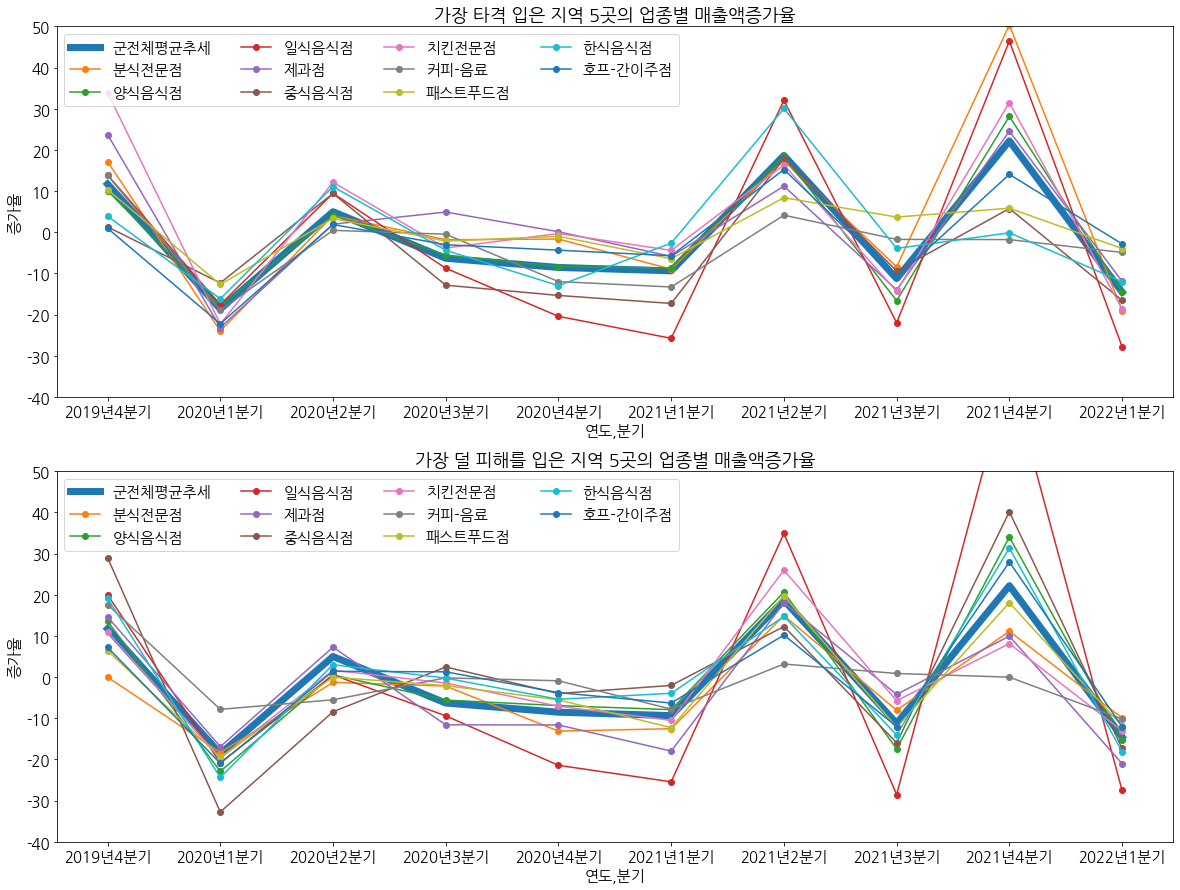

In [133]:
# 그래프 그리기

# 타격이 심각한 곳
plt.subplot(2, 1, 1) # 2행1열 공간의 첫번째 부분에 들어갈 그래프

plt.plot(x, inc_gu_trand2.iloc[25], linewidth = '7.0') # 평균 추세, 선 두께 설정
for i in range(len(incbad5_type)) :
    plt.plot(x, incbad5_type.iloc[i], marker='o')

plt.xlabel('연도,분기') # x축 제목
plt.xticks(x, incbad5_type.columns.to_list()) # 실제로 x축에 표기할 내용

plt.ylabel('증가율') # y축 제목

plt.ylim(-40, 50) # y축 표기범위

legend_list = ['군전체평균추세'] + [i for i in incbad5_type.index.to_list()] # 범주
plt.legend(legend_list, ncol=4, loc='upper left')

plt.title('가장 타격 입은 지역 5곳의 업종별 매출액증가율')
plt.rc('font', size=15)  # 글자 크기


# 타격이 가장 덜 심각한 곳
plt.subplot(2, 1, 2) # 2행1열 공간의 두번째 부분에 들어갈 그래프

plt.plot(x, inc_gu_trand2.iloc[25], linewidth = '7.0') # 평균 추세, 선 두께 설정
for i in range(len(incless5_type)) :
    plt.plot(x, incless5_type.iloc[i], marker='o')

plt.xlabel('연도,분기') # x축 제목
plt.xticks(x, incless5_type.columns.to_list()) # 실제로 x축에 표기할 내용

plt.ylabel('증가율') # y축 제목

plt.ylim(-40, 50) # y축 표기범위

legend_list = ['군전체평균추세'] + [i for i in incless5_type.index.to_list()] # 범주
plt.legend(legend_list, ncol=4, loc='upper left')

plt.title('가장 덜 피해를 입은 지역 5곳의 업종별 매출액증가율')
plt.rcParams["figure.figsize"] = [20,15] # 그래프 전체 크기
plt.rc('font', size=15)  # 글자 크기


plt.show() # 결과

상권별, 업종별 비교에서 모두 유의미한 차이를 찾기 어려워보인다.

salse의 데이터만으로는 마땅한 이유를 찾을 수 없다.